In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
from qiskit import *

In [2]:
backend = Aer.get_backend('qasm_simulator') # Quantum Simulator

The goal is to create an initial state that is dominated by $\vert 00 \rangle$ and has an equal probability of being in $\vert01\rangle$ and $\vert 11 \rangle$, while also neglecting $\vert10\rangle$ 

$ \vert \psi \rangle =  CH(1,0) R^y(2\theta,0) \vert 00 \rangle =\\$
$   \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & \frac{1}{\sqrt{2}} & 0 & \frac{1}{\sqrt{2}} \\
        0 & 0 & 1 & 0 \\
        0 & \frac{1}{\sqrt{2}} & 0 & -\frac{1}{\sqrt{2}}
    \end{pmatrix} 
    \begin{pmatrix}
        \cos(\theta) & -\sin(\theta) & 0 & 0 \\
        \sin(\theta) & \cos(\theta) & 0 & 0 \\
        0 & 0 & \cos(\theta) & -\sin(\theta) \\
        0 & 0 & \sin(\theta) & \cos(\theta)
   \end{pmatrix}
    \begin{pmatrix}
        1 \\ 0 \\ 0 \\ 0
    \end{pmatrix} =\\ \\
    \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & \frac{1}{\sqrt{2}} & 0 & \frac{1}{\sqrt{2}} \\
        0 & 0 & 1 & 0 \\
        0 & \frac{1}{\sqrt{2}} & 0 & -\frac{1}{\sqrt{2}}
    \end{pmatrix} 
    \begin{pmatrix}
        \cos(\theta) \\ \sin(\theta) \\ 0 \\ 0
    \end{pmatrix} = \\
    \begin{pmatrix}
        \cos(\theta) \\ \frac{1}{\sqrt{2}} \sin(\theta) \\ 0 \\ \frac{1}{\sqrt{2}} \sin(\theta)
    \end{pmatrix}
$

In [3]:
def init_state(circuit,theta):
    circuit.ry(theta,0)
    circuit.ch(1,0)
    return circuit 

The init_state function takes in your circuit and a variable $\theta$ and creates our desired initial state.

In [4]:
def measure(circuit): 
    """This function measures the circuit at the end of a run"""
    circuit.measure(range(2),range(2))
    return circuit

def count_states(circuit,shots=1024):
    """This function is responsible for executing a run, and extracting the state counts"""
    job_sim = execute(circuit, backend, shots=shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circuit)
    return counts

def prob(state,count,shots):
    """This function takes the counts and returns the probability of the desired state"""
    if (state in count.keys()) == False:
        return 0
    else:
        probability = count[str(state)] / shots
        return probability 

In [5]:
def P(theta,shots = 1024):
    """P_{i}"""
    c = QuantumCircuit(2,2) # Set up the default circuit with 2 qubits
    init_state(c,theta) # initialize the qubits
    measure(c) 
    counts = count_states(c,shots)
    return counts

def Pxx(theta,shots = 1024):
    """P_{i}^{xx}"""
    c = QuantumCircuit(2,2)
    init_state(c,theta)
    c.h(0)
    c.h(1)
    measure(c)
    counts = count_states(c,shots)
    return counts

def Pyy(theta,shots = 1024):
    """P_{i}^{yy}"""
    c = QuantumCircuit(2,2)
    init_state(c,theta)
    c.rx(np.pi/2,0)
    c.rx(np.pi/2,1)
    measure(c)
    counts = count_states(c,shots)
    return counts

def Pix(theta,shots = 1024):
    """P_{i}^{x}"""
    c = QuantumCircuit(2,2) 
    init_state(c,theta)
    c.h(0)
    measure(c)
    counts = count_states(c,shots)
    return counts

def Pzx(theta,shots = 1024):
    """P_{i}^{x}"""
    c = QuantumCircuit(2,2) 
    init_state(c,theta)
    c.h(0)
    measure(c)
    counts = count_states(c,shots)
    return counts

In [35]:
def Hamiltonian(theta,shots=1024,g=1):
    # experiments
    e1 =  P(theta,shots=shots)
    e2 = Pxx(theta,shots=shots)
    e3 = Pix(theta,shots=shots)
    e4 = Pzx(theta,shots=shots)
    e5 = Pyy(theta,shots=shots)
    # probabilities
    P_00 = prob('00',e1,shots=shots) 
    
    Pxx_00 = prob('00',e2,shots=shots)
    Pxx_11 = prob('11',e2,shots=shots)
    
    Pix_00 = prob('00',e3,shots=shots)
    Pix_10 = prob('10',e3,shots=shots)
    
    Pzx_00 = prob('00',e4,shots=shots)
    Pzx_11 = prob('11',e4,shots=shots)
    
    Pyy_00 = prob('00',e5,shots=shots)
    Pyy_11 = prob('11',e5,shots=shots)
    #hamiltonian
    H_E = 3*(1 - P_00)
    H_B = (1/2)*( 5*(Pxx_00 + Pxx_11) + 5*(Pix_00 + Pix_10) + 3*(Pzx_00 + Pzx_11) - 3*(Pyy_00 + Pyy_11) -5)
    H = (g**2 /2)*H_E - (1/(2*g**2))*H_B
    return H 

In [36]:
theta_list = np.linspace(0,2,10)

In [42]:
g = 0.001
H_list = np.array([ Hamiltonian(theta,shots=10**3,g=g) for theta in theta_list]) 
# Hamiltonian(theta_list[0],shots=10**3,g=g)

In [43]:
M = (0.5*g**2)*np.array([[0,0,0,0],[0,3,0,0],[0,0,3,0],[0,0,0,3]]) - (0.5/g**2)*np.array([[0,2,0,2],[2,0,0.5,0],[0,0.5,0,0.5],[2,0,0.5,0] ])
minE = np.min( np.linalg.eig(M)[0] )

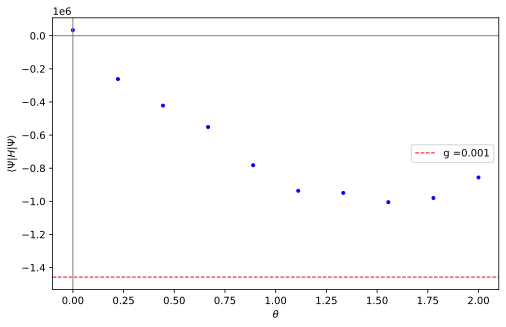

In [44]:
plt.figure(figsize=[8,5])
plt.plot(theta_list,H_list,'b.')
# plt.plot(theta_list,H_list_6,'g-')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$ \langle \Psi \vert H \vert \Psi \rangle $')
plt.axhline(0,color='grey',lw=1)
plt.axvline(0,color='grey',lw=1)
plt.axhline( minE ,color='red',ls='--',label='g ='+str(g),lw=1)
plt.legend()
plt.show()